# Understanding Soft Actor-Critic (SAC): A Complete Guide

# Table of Contents

- [Introduction](#introduction)
- [What is SAC?](#what-is-sac)
  - [Key Idea: Maximum Entropy RL](#key-idea-maximum-entropy-rl)
- [Where and How SAC is Used](#where-and-how-sac-is-used)
- [Mathematical Foundation of SAC](#mathematical-foundation-of-sac)
  - [The Maximum Entropy Objective](#the-maximum-entropy-objective)
  - [Soft State Value Function ($V_{soft}$)](#soft-state-value-function-v_soft)
  - [Soft Action Value Function ($Q_{soft}$)](#soft-action-value-function-q_soft)
  - [Soft Bellman Backup (Critic Update)](#soft-bellman-backup-critic-update)
  - [Policy Improvement (Actor Update)](#policy-improvement-actor-update)
  - [Reparameterization Trick](#reparameterization-trick)
  - [Entropy Temperature ($\alpha$) Tuning](#entropy-temperature-\alpha--tuning)
  - [Double Q-Learning and Target Networks](#double-q-learning-and-target-networks)
- [Step-by-Step Explanation of SAC](#step-by-step-explanation-of-sac)
- [Key Components of SAC](#key-components-of-sac)
  - [Stochastic Actor Network (Policy)](#stochastic-actor-network-policy)
  - [Critic Networks (Twin Q-Networks)](#critic-networks-twin-q-networks)
  - [Target Critic Networks](#target-critic-networks)
  - [Entropy Temperature ($\alpha$)](#entropy-temperature-\alpha)
  - [Replay Buffer](#replay-buffer)
  - [Soft Target Updates](#soft-target-updates)
  - [Hyperparameters](#hyperparameters)
- [Practical Example: Pendulum Environment](#practical-example-pendulum-environment)
- [Setting up the Environment](#setting-up-the-environment)
- [Creating the Continuous Environment (Gymnasium)](#creating-the-continuous-environment-gymnasium)
- [Implementing the SAC Algorithm](#implementing-the-sac-algorithm)
  - [Defining the Actor Network (Gaussian Policy)](#defining-the-actor-network-gaussian-policy)
  - [Defining the Critic Network (Double Q)](#defining-the-critic-network-double-q)
  - [Defining the Replay Memory](#defining-the-replay-memory)
  - [Soft Update Function](#soft-update-function)
  - [The SAC Update Step](#the-sac-update-step)
- [Running the SAC Algorithm](#running-the-sac-algorithm)
  - [Hyperparameter Setup](#hyperparameter-setup)
  - [Initialization](#initialization)
  - [Training Loop](#training-loop)
- [Visualizing the Learning Process](#visualizing-the-learning-process)
- [Analyzing the Learned Policy (Testing)](#analyzing-the-learned-policy-testing)
- [Common Challenges and Solutions in SAC](#common-challenges-and-solutions-in-sac)
- [Conclusion](#conclusion)

## Introduction

Soft Actor-Critic (SAC) is a state-of-the-art **off-policy actor-critic** algorithm designed for **continuous action spaces**, building significantly upon ideas from DDPG, TD3, and incorporating the principle of **maximum entropy reinforcement learning**. Its goal is to learn a policy that maximizes not only the expected cumulative reward but also the policy's entropy. This addition encourages exploration, improves robustness to noise, and often leads to faster and more stable learning compared to previous methods like DDPG and TD3.

## What is SAC?

SAC learns three main components (often implemented using five networks):

1.  **Actor ($\pi(a|s; \theta)$):** A *stochastic* policy network that maps states to a probability distribution over actions (typically Gaussian for continuous control). Parameterized by $\theta$.
2.  **Critic (Twin Q-Networks $Q(s, a; \phi_1), Q(s, a; \phi_2)$):** Two separate Q-value networks that estimate the *soft* action value (expected return plus entropy). Using two critics helps mitigate Q-value overestimation. Parameterized by $\phi_1, \phi_2$.
3.  **Entropy Temperature ($\alpha$):** A positive coefficient that weights the importance of the entropy term in the objective. This can be a fixed hyperparameter or automatically tuned.

Like DDPG, it employs:
- **Replay Buffer:** For off-policy learning and sample efficiency.
- **Target Networks:** Maintains slowly updated target networks for the critic(s) to stabilize Q-learning targets.
- **Soft Updates:** Uses slow, smooth updates for the target networks.

### Key Idea: Maximum Entropy RL
Standard RL aims to maximize the expected sum of discounted rewards: $\mathbb{E}[\sum_t \gamma^t R(s_t, a_t)]$. Maximum Entropy RL modifies this objective to include the policy's entropy at each step:
$$ J(\pi) = \mathbb{E}_{\tau \sim \pi} \left[ \sum_{t=0}^T \gamma^t \left( R(s_t, a_t) + \alpha H(\pi(\cdot|s_t)) \right) \right] $$
where $H(\pi(\cdot|s_t))$ is the entropy of the policy distribution at state $s_t$, and $\alpha$ is the temperature parameter controlling the trade-off between reward maximization and entropy maximization.

**Benefits of Maximizing Entropy:**
- **Improved Exploration:** The agent is incentivized to explore more diverse actions, potentially discovering better solutions faster and avoiding premature convergence.
- **Robustness:** Policies with higher entropy tend to be more robust to perturbations and noise in the environment or execution.
- **Compositionality:** Policies learned via max-entropy RL can sometimes be combined more easily for hierarchical tasks.

## Where and How SAC is Used

SAC is a leading algorithm for continuous control tasks and is widely applied in:

1.  **Robotics:** Particularly effective for learning complex locomotion and manipulation skills in simulation (MuJoCo, PyBullet) and increasingly in the real world.
2.  **Continuous Control Benchmarks:** Often achieves top performance on standard benchmarks like Pendulum, Hopper, Walker2d, Humanoid, etc.
3.  **Autonomous Systems:** Areas requiring smooth, continuous control actions.

SAC is suitable when:
- The action space is continuous.
- High sample efficiency is desired (off-policy).
- Robustness and good exploration are important.
- Stable learning is preferred over potentially faster but more brittle methods.

## Mathematical Foundation of SAC

### The Maximum Entropy Objective
As stated earlier, the objective is to find a policy $\pi$ that maximizes:
$$ J(\pi) = \sum_{t=0}^T \mathbb{E}_{(s_t, a_t) \sim \rho_\pi} [\gamma^t (R(s_t, a_t) + \alpha H(\pi(\cdot|s_t)))] $$

### Soft State Value Function ($V_{soft}$)
In this framework, the value functions are also modified ('softened') to account for the expected future entropy. The soft state value function is defined implicitly via a Bellman equation:
$$ V_{soft}^{\pi}(s) = \mathbb{E}_{a \sim \pi(\cdot|s)} [ Q_{soft}^{\pi}(s,a) - \alpha \log \pi(a|s) ] $$
It represents the expected return plus expected future entropy starting from state $s$.

### Soft Action Value Function ($Q_{soft}$)
The soft action value function satisfies the soft Bellman equation:
$$ Q_{soft}^{\pi}(s,a) = R(s,a) + \gamma \mathbb{E}_{s' \sim P} [ V_{soft}^{\pi}(s') ] $$
Substituting the definition of $V_{soft}^{\pi}(s')$ into the $Q_{soft}^{\pi}$ equation gives the Bellman backup operator used for training the critic(s):
$$ Q_{soft}^{\pi}(s,a) \approx R(s,a) + \gamma \mathbb{E}_{s' \sim P, a' \sim \pi(\cdot|s')} [ Q_{soft}^{\pi}(s', a') - \alpha \log \pi(a'|s') ] $$

### Soft Bellman Backup (Critic Update)
The critic networks ($Q_{\phi_1}, Q_{\phi_2}$) are trained to minimize the soft Bellman residual using samples $(s, a, r, s', d)$ from the replay buffer $\mathcal{D}$. The target value $y(r, s', d)$ is:
$$ y(r, s', d) = r + \gamma (1-d) \left( \min_{i=1,2} Q'_{\phi'_i}(s', a') - \alpha \log \pi_	heta(a'|s') \right), \quad \text{where } a' \sim \pi_	heta(\cdot|s') $$
Note:
- $Q'_{\phi'_i}$ are the *target* critic networks.
- $a'$ is sampled from the *current* policy network $\pi_	heta$ (using the reparameterization trick).
- The minimum of the two target Q-values is used (clipped double Q-learning).
- $\alpha$ is the current entropy temperature.

The loss for each critic $i=1,2$ is:
$$ L(\phi_i) = \mathbb{E}_{(s,a,r,s',d) \sim \mathcal{D}} [ (Q_{\phi_i}(s,a) - y(r, s', d))^2 ] $$

### Policy Improvement (Actor Update)
The actor $\pi_	heta$ is updated to maximize the expected soft value, which corresponds to minimizing the following loss:
$$ L(	heta) = \mathbb{E}_{s \sim \mathcal{D}, a \sim \pi_	heta(\cdot|s)} [ \alpha \log \pi_	heta(a|s) - \min_{i=1,2} Q_{\phi_i}(s, a) ] $$
This encourages the policy to output actions $a$ that have high soft Q-values and high entropy (low negative log-probability).

### Reparameterization Trick
To allow gradients to flow from the critic's Q-value estimate back into the actor network parameters $\theta$ when minimizing $L(\theta)$, the sampling process $a \sim \pi_	heta(\cdot|s)$ is made differentiable using the reparameterization trick. For a Gaussian policy $\pi_	heta(\cdot|s) = \mathcal{N}(\mu_	heta(s), \sigma_	heta(s))$, an action is sampled as:
$$ a = 	anh(\mu_	heta(s) + \sigma_	heta(s) \cdot \xi), \quad \xi \sim \mathcal{N}(0, I) $$
The actor network outputs $\mu_	heta(s)$ and $\log \sigma_	heta(s)$. The $	anh$ function squashes the output to a bounded range (e.g., [-1, 1]), requiring a correction term when calculating the log-probability $\log \pi_	heta(a|s)$ used in the actor and critic target updates.

### Entropy Temperature ($\alpha$) Tuning
Instead of fixing $\alpha$, it can be learned automatically by defining a target entropy $\bar{H}$ (often set heuristically, e.g., $-\text{dim}(\mathcal{A})$) and optimizing $\alpha$ to match the policy's average entropy to this target. The loss for $\alpha$ (optimized via its logarithm $\log \alpha$) is:
$$ L(\log \alpha) = \mathbb{E}_{a_t \sim \pi_	heta} [ -\log \alpha ( \log \pi_	heta(a_t|s_t) + \bar{H} )^{\text{detached}} ] $$
Minimizing this loss via gradient descent adjusts $\alpha$: if entropy is too low, $\alpha$ increases; if too high, $\alpha$ decreases.

### Double Q-Learning and Target Networks
- **Double Q-Learning:** Using two critic networks ($Q_1, Q_2$) and taking the minimum of their target values helps reduce the overestimation bias common in Q-learning.
- **Target Networks:** Separate target networks ($Q'_1, Q'_2$) are used for calculating the Bellman target $y$. They are updated slowly using soft updates ($	au$) towards the main critic networks.

## Step-by-Step Explanation of SAC

1.  **Initialize**: Actor network $\pi_	heta$, two Critic networks $Q_{\phi_1}, Q_{\phi_2}$.
2.  **Initialize**: Two Target Critic networks $Q'_{\phi'_1}, Q'_{\phi'_2}$ with $\phi'_1 \leftarrow \phi_1$, $\phi'_2 \leftarrow \phi_2$.
3.  **Initialize**: Replay buffer $\mathcal{D}$.
4.  **Initialize**: Entropy temperature $\alpha$ (either fixed or learnable via $\log \alpha$). If learnable, initialize target entropy $\bar{H}$ and $\log \alpha$ optimizer.
5.  **Initialize**: Actor and Critic optimizers.
6.  **For each episode**:
    a.  Reset environment, get initial state $s_0$.
    b.  **For each step $t$**:
        i.   Sample action $a_t \sim \pi_	heta(\cdot|s_t)$ (using reparameterization trick, add noise only if needed - stochastic policy explores).
        ii.  Execute $a_t$, observe reward $r_t$, next state $s_{t+1}$, done flag $d_t$.
        iii. Store transition $(s_t, a_t, r_t, s_{t+1}, d_t)$ in $\mathcal{D}$.
        iv.  **Update Step (after collecting enough data, e.g., every step or few steps)**:
            1.  Sample mini-batch of $N$ transitions from $\mathcal{D}$.
            2.  **Update Critic(s)**:
                - Compute target values $y_j$ using target critics, current actor, and $\alpha$.
                - Minimize MSE loss $L(\phi_1)$ and $L(\phi_2)$ via gradient descent.
            3.  **Update Actor**: 
                - Compute actor loss $L(\theta)$ using current critics and current actor.
                - Minimize $L(\theta)$ via gradient descent.
            4.  **Update Alpha (if tuning)**:
                - Compute alpha loss $L(\log \alpha)$.
                - Minimize $L(\log \alpha)$ via gradient descent.
            5.  **Update Target Critics**: Perform soft updates:
                 $\phi'_i \leftarrow \tau \phi_i + (1 - \tau) \phi'_i$ for $i=1,2$.
        v.   $s_t \leftarrow s_{t+1}$.
        vi.  If $d_t$, break episode.
7.  **Repeat**: Until convergence or max episodes/steps.

## Key Components of SAC

### Stochastic Actor Network (Policy)
- Maps state $s$ to parameters (e.g., mean, log std dev) of a distribution (e.g., Gaussian) over actions $a$.
- Trained to maximize soft Q-values and entropy.
- Uses reparameterization trick for differentiability.

### Critic Networks (Twin Q-Networks)
- Two networks ($Q_1, Q_2$) estimating the soft action value $Q_{soft}(s,a)$.
- Trained using soft Bellman targets.

### Target Critic Networks
- Slowly updated copies ($Q'_1, Q'_2$) used to compute stable Bellman targets.

### Entropy Temperature ($\alpha$)
- Balances reward vs. entropy maximization. Can be fixed or automatically tuned.

### Replay Buffer
- Standard off-policy buffer storing transitions.

### Soft Target Updates
- Slow blending of main critic parameters into target critic parameters ($	au$).

### Hyperparameters
- Buffer size, batch size, learning rates (actor, critic, alpha).
- Target update rate ($	au$), discount ($\gamma$).
- Initial $\alpha$ and target entropy $\bar{H}$ (if tuning $\alpha$).
- Network architectures.

## Practical Example: Pendulum Environment

We use `Pendulum-v1` from Gymnasium to demonstrate SAC in a continuous action space. **Requires `gymnasium`.**

## Practical Example: Pendulum Environment

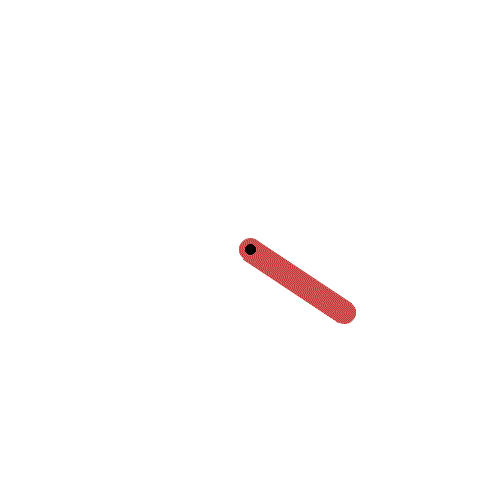

### Why Pendulum? (Continuous Actions and Exploration)

SAC is well-suited for environments with continuous action spaces like `Pendulum-v1`. While Grid World offers discrete actions (Up, Down, Left, Right), SAC excels when the agent needs to learn fine-grained control.  The `Pendulum-v1` environment is a standard benchmark, advantageous for demonstrating SAC's capabilities because:

- **Continuous State:** `[cos(theta), sin(theta), theta_dot]` represents the pendulum's state (angle and angular velocity).

- **Continuous Action:** Torque applied to the pendulum's joint.  This is a single continuous value, typically within the range of [-2.0, 2.0].

- **Emphasis on Exploration:** SAC inherently encourages exploration by maximizing entropy alongside reward.  This is particularly useful in the `Pendulum-v1` environment, where finding the optimal control strategy often requires trying different levels of torque and observing the resulting dynamics.  The continuous action space provides the agent with a vast range of possible behaviors to explore.

Using this environment allows us to correctly demonstrate SAC's handling of continuous actions and its exploration strategy.  **This requires the `gymnasium` library, deviating slightly from the 'basic libraries only' constraint of the reference DQN notebook, as SAC is fundamentally designed for continuous action spaces where exploration is key.**

# Setting up the Environment

Import libraries, including `gymnasium`.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from collections import namedtuple, deque
from itertools import count
from typing import List, Tuple, Dict, Optional, Callable, Any
import copy

# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal # Use Normal distribution for continuous actions

torch.set_default_tensor_type(torch.FloatTensor)  # Set default to float32

# Import Gymnasium
try:
    import gymnasium as gym
except ImportError:
    print("Gymnasium not found. Please install using 'pip install gymnasium' or 'pip install gym[classic_control]'")
    gym = None

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

%matplotlib inline

Using device: cpu


c:\Users\faree\Desktop\all-rl-algorithms\.venv-all-rl-algos\lib\site-packages\torch\__init__.py:1236: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\tensor\python_tensor.cpp:436.)
  _C._set_default_tensor_type(t)


# Creating the Continuous Environment (Gymnasium)

Instantiate Pendulum-v1.

In [2]:
# Instantiate the Pendulum environment
if gym is not None:
    try:
        env = gym.make('Pendulum-v1')
        env.reset(seed=seed)
        env.action_space.seed(seed)

        n_observations_sac = env.observation_space.shape[0]
        n_actions_sac = env.action_space.shape[0]
        action_low_sac = env.action_space.low[0]
        action_high_sac = env.action_space.high[0]

        print(f"Pendulum Environment:")
        print(f"State Dim: {n_observations_sac}")
        print(f"Action Dim: {n_actions_sac}")
        print(f"Action Low: {action_low_sac}")
        print(f"Action High: {action_high_sac}")
    except Exception as e:
        print(f"Error creating Gymnasium environment: {e}")
        n_observations_sac = 3
        n_actions_sac = 1
        action_low_sac = -2.0
        action_high_sac = 2.0
        env = None
else:
    print("Gymnasium not available. Cannot create Pendulum environment.")
    n_observations_sac = 3
    n_actions_sac = 1
    action_low_sac = -2.0
    action_high_sac = 2.0
    env = None

Pendulum Environment:
State Dim: 3
Action Dim: 1
Action Low: -2.0
Action High: 2.0


# Implementing the SAC Algorithm

Define the SAC components: Actor, Critic, Replay Buffer, Update logic.

### Defining the Actor Network (Gaussian Policy)

Outputs mean and log standard deviation for a Gaussian distribution. Actions are sampled, squashed with `tanh`, and log probabilities are corrected.

In [3]:
LOG_STD_MAX = 2
LOG_STD_MIN = -20
EPSILON = 1e-6 # Small number for numerical stability

class ActorNetworkSAC(nn.Module):
    """ Stochastic Gaussian Actor Network for SAC """
    def __init__(self, n_observations: int, n_actions: int, action_high_bound: float):
        super(ActorNetworkSAC, self).__init__()
        self.action_high_bound = action_high_bound
        # Architecture (adjust complexity as needed)
        self.layer1 = nn.Linear(n_observations, 256)
        self.layer2 = nn.Linear(256, 256)
        self.mean_layer = nn.Linear(256, n_actions) # Outputs mean
        self.log_std_layer = nn.Linear(256, n_actions) # Outputs log standard deviation

    def forward(self, state: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Outputs action and its log probability, using reparameterization and tanh squashing.
        Parameters:
        - state (torch.Tensor): Input state.
        Returns:
        - Tuple[torch.Tensor, torch.Tensor]:
            - action: Squashed action sampled from the policy.
            - log_prob: Log probability of the squashed action.
        """
        # Check if state is a single sample and add batch dimension if needed
        add_batch_dim = False
        if state.dim() == 1:
            state = state.unsqueeze(0)  # Add batch dimension
            add_batch_dim = True
            
        x = F.relu(self.layer1(state))
        x = F.relu(self.layer2(x))
        
        mean = self.mean_layer(x)
        log_std = self.log_std_layer(x)
        # Clamp log_std for stability
        log_std = torch.clamp(log_std, LOG_STD_MIN, LOG_STD_MAX)
        std = torch.exp(log_std)

        # Create Gaussian distribution
        normal_dist = Normal(mean, std)

        # Reparameterization trick: sample pre-squashed action
        # Use rsample() for differentiable sampling
        z = normal_dist.rsample()
        
        # Apply tanh squashing to get bounded action
        action = torch.tanh(z)
        
        # Calculate log-probability with correction for tanh squashing
        # log_prob = log_normal(z) - log(1 - tanh(z)^2)
        log_prob = normal_dist.log_prob(z) - torch.log(1 - action.pow(2) + EPSILON)
        
        # Sum across action dimensions (proper handling of dimensions)
        if log_prob.dim() > 1:
            log_prob = log_prob.sum(dim=1, keepdim=True)
        else:
            log_prob = log_prob.sum(keepdim=True)
        
        # Scale action to environment bounds
        action = action * self.action_high_bound
        
        # Remove batch dimension if it was added
        if add_batch_dim:
            action = action.squeeze(0)
            log_prob = log_prob.squeeze(0)
            
        return action, log_prob

### Defining the Critic Network (Double Q)

Contains two separate Q-networks internally.

In [4]:
class CriticNetworkSAC(nn.Module):
    """ Twin Q-Value Critic Network for SAC """
    def __init__(self, n_observations: int, n_actions: int):
        super(CriticNetworkSAC, self).__init__()

        # Q1 Architecture
        self.q1_layer1 = nn.Linear(n_observations + n_actions, 256)
        self.q1_layer2 = nn.Linear(256, 256)
        self.q1_output = nn.Linear(256, 1)

        # Q2 Architecture
        self.q2_layer1 = nn.Linear(n_observations + n_actions, 256)
        self.q2_layer2 = nn.Linear(256, 256)
        self.q2_output = nn.Linear(256, 1)

    def forward(self, state: torch.Tensor, action: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Outputs the Q-values from both internal critics.
        Parameters:
        - state (torch.Tensor): Input state tensor.
        - action (torch.Tensor): Input action tensor.
        Returns:
        - Tuple[torch.Tensor, torch.Tensor]: Q1(s, a) and Q2(s, a).
        """
        sa = torch.cat([state, action], dim=1) # Concatenate state and action

        # Q1 forward pass
        q1 = F.relu(self.q1_layer1(sa))
        q1 = F.relu(self.q1_layer2(q1))
        q1 = self.q1_output(q1)

        # Q2 forward pass
        q2 = F.relu(self.q2_layer1(sa))
        q2 = F.relu(self.q2_layer2(q2))
        q2 = self.q2_output(q2)

        return q1, q2

### Defining the Replay Memory

Standard buffer, identical to DDPG/DQN version.

In [5]:
# Define the structure for storing transitions
# Using the same Transition namedtuple as DDPG/DQN
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', 'done'))

# Define the Replay Memory class (Identical to DDPG/DQN version)
class ReplayMemory(object):
    def __init__(self, capacity: int):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args: Any) -> None:
        processed_args = []
        for arg in args:
            if isinstance(arg, torch.Tensor):
                # Ensure tensors are float32 and on CPU
                processed_args.append(arg.to(torch.float32).cpu())
            elif isinstance(arg, np.ndarray):
                # Convert numpy array to float32 tensor
                processed_args.append(torch.from_numpy(arg).to(torch.float32).cpu())
            elif isinstance(arg, (bool, float, int)):
                # Store scalar values as float32 tensors
                processed_args.append(torch.tensor([arg], dtype=torch.float32))
            else:
                processed_args.append(arg)
        self.memory.append(Transition(*processed_args))

    def sample(self, batch_size: int) -> List[Transition]:
        return random.sample(self.memory, batch_size)

    def __len__(self) -> int:
        return len(self.memory)

### Soft Update Function

Reusing the soft update function.

In [6]:
def soft_update(target_net: nn.Module, main_net: nn.Module, tau: float) -> None:
    """ Performs a soft update of the target network parameters. (Identical) """
    for target_param, main_param in zip(target_net.parameters(), main_net.parameters()):
        target_param.data.copy_(tau * main_param.data + (1.0 - tau) * target_param.data)

### The SAC Update Step

Performs the critic, actor, and (optionally) alpha updates.

In [7]:
def update_sac(memory: ReplayMemory,
               batch_size: int,
               actor: ActorNetworkSAC,
               critic: CriticNetworkSAC,
               target_critic: CriticNetworkSAC,
               actor_optimizer: optim.Optimizer,
               critic_optimizer: optim.Optimizer,
               log_alpha: torch.Tensor,
               alpha_optimizer: optim.Optimizer,
               target_entropy: float,
               gamma: float,
               tau: float) -> Tuple[float, float, float, float]:
    """
    Performs one SAC update step (critic, actor, alpha).
    """
    # Ensure enough samples are available in memory
    if len(memory) < batch_size:
        return 0.0, 0.0, 0.0, torch.exp(log_alpha.detach()).item()

    # Sample a batch of transitions from memory
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    # Unpack and move data to the appropriate device with explicit dtype=float32
    state_batch = torch.cat([s.view(1, -1).float() for s in batch.state]).to(device)
    action_batch = torch.cat([a.view(1, -1).float() for a in batch.action]).to(device)
    reward_batch = torch.cat([r.view(1, -1).float() for r in batch.reward]).to(device)
    next_state_batch = torch.cat([s.view(1, -1).float() for s in batch.next_state]).to(device)
    done_batch = torch.cat([d.view(1, -1).float() for d in batch.done]).to(device)

    # --- Critic Update ---
    with torch.no_grad():
        # Get next action and log probability from the current policy
        next_action, next_log_prob = actor(next_state_batch)
        
        # Get target Q values from the target critics
        q1_target_next, q2_target_next = target_critic(next_state_batch, next_action)
        q_target_next = torch.min(q1_target_next, q2_target_next)  # Min of two Q-values
        
        # Calculate the soft target:
        # soft_target = Q_target_next - α * log_prob
        alpha = torch.exp(log_alpha.detach()).float()
        soft_target = q_target_next - alpha * next_log_prob
        
        # Compute the target value for the Bellman equation:
        # y = reward + γ * (1 - done) * soft_target
        y = reward_batch + gamma * (1.0 - done_batch) * soft_target

    # Get current Q estimates from the critic
    q1_current, q2_current = critic(state_batch, action_batch)

    # Calculate critic losses (Mean Squared Error):
    # critic_loss = MSE(Q1_current, y) + MSE(Q2_current, y)
    critic1_loss = F.mse_loss(q1_current, y)
    critic2_loss = F.mse_loss(q2_current, y)
    critic_loss = critic1_loss + critic2_loss

    # Optimize the critic networks
    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()

    # --- Actor Update ---
    # Freeze critic gradients to avoid updating them during actor optimization
    for p in critic.parameters():
        p.requires_grad = False

    # Get actions and log probabilities for the current states from the actor
    pi_action, pi_log_prob = actor(state_batch)
    
    # Get Q values for these actions from the critic
    q1_pi, q2_pi = critic(state_batch, pi_action)
    min_q_pi = torch.min(q1_pi, q2_pi)  # Min of two Q-values

    # Calculate actor loss:
    # actor_loss = E[α * log_prob - Q_min]
    actor_loss = (alpha * pi_log_prob - min_q_pi).mean()

    # Optimize the actor network
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()

    # Unfreeze critic gradients
    for p in critic.parameters():
        p.requires_grad = True
        
    # --- Alpha (Entropy Temperature) Update ---
    # Calculate alpha loss:
    # alpha_loss = -E[log_alpha * (log_prob + target_entropy)]
    target_entropy_tensor = torch.tensor(target_entropy, dtype=torch.float32, device=device)
    alpha_loss = -(log_alpha * (pi_log_prob.detach().float() + target_entropy_tensor)).mean()

    # Optimize alpha (if auto-tuning is enabled)
    if alpha_optimizer is not None:
        alpha_optimizer.zero_grad()
        alpha_loss.backward()
        alpha_optimizer.step()
    
    # Get the current value of alpha
    current_alpha = torch.exp(log_alpha.detach()).item()

    # --- Update Target Networks ---
    # Perform a soft update of the target critic networks:
    # θ_target = τ * θ_main + (1 - τ) * θ_target
    soft_update(target_critic, critic, tau)

    # Return the losses and the current alpha value
    return critic_loss.item(), actor_loss.item(), alpha_loss.item(), current_alpha

# Running the SAC Algorithm

Set up hyperparameters, initialize everything, and run the SAC training loop.

### Hyperparameter Setup

Define SAC hyperparameters for Pendulum.

In [8]:
# Hyperparameters for SAC on Pendulum-v1
BUFFER_SIZE_SAC = int(1e6)     # Replay buffer capacity
BATCH_SIZE_SAC = 256           # Mini-batch size
GAMMA_SAC = 0.99               # Discount factor
TAU_SAC = 5e-3                 # Soft update factor
LR_SAC = 3e-4                  # Learning rate for actor, critic, and alpha
INITIAL_ALPHA = 0.2            # Initial entropy temperature (or fixed value if not tuning)
AUTO_TUNE_ALPHA = True         # Whether to automatically tune alpha
TARGET_ENTROPY = -float(n_actions_sac) # Heuristic target entropy: -|Action Space Dim|

NUM_EPISODES_SAC = 100         # Number of training episodes
MAX_STEPS_PER_EPISODE_SAC = 200 # Pendulum typically uses 200 steps
START_STEPS = 1000             # Number of initial random steps before training starts
UPDATE_EVERY_SAC = 1           # Perform update after every environment step

### Initialization

Initialize all networks, target networks, optimizers, alpha, and buffer.

In [9]:
if env is None:
    raise RuntimeError("Gymnasium environment 'Pendulum-v1' could not be created.")

# Initialize Networks
actor_sac = ActorNetworkSAC(n_observations_sac, n_actions_sac, action_high_sac).to(device)
critic_sac = CriticNetworkSAC(n_observations_sac, n_actions_sac).to(device)
target_critic_sac = CriticNetworkSAC(n_observations_sac, n_actions_sac).to(device)
target_critic_sac.load_state_dict(critic_sac.state_dict())
# Freeze target critic parameters
for p in target_critic_sac.parameters():
    p.requires_grad = False

# Initialize Optimizers
actor_optimizer_sac = optim.Adam(actor_sac.parameters(), lr=LR_SAC)
critic_optimizer_sac = optim.Adam(critic_sac.parameters(), lr=LR_SAC)

# Initialize Alpha (Entropy Temperature)
# Initialize Alpha (Entropy Temperature) with explicit dtype
if AUTO_TUNE_ALPHA:
    # Learn log_alpha for stability with explicit float32
    log_alpha_sac = torch.tensor(np.log(INITIAL_ALPHA), dtype=torch.float32, requires_grad=True, device=device)
    alpha_optimizer_sac = optim.Adam([log_alpha_sac], lr=LR_SAC)
else:
    log_alpha_sac = torch.tensor(np.log(INITIAL_ALPHA), dtype=torch.float32, requires_grad=False, device=device)
    alpha_optimizer_sac = None # No optimizer needed if alpha is fixed

# Make sure TARGET_ENTROPY is also float32
TARGET_ENTROPY_TENSOR = torch.tensor(-float(n_actions_sac), dtype=torch.float32, device=device)

# Initialize Replay Memory
memory_sac = ReplayMemory(BUFFER_SIZE_SAC)

# Lists for plotting
sac_episode_rewards = []
sac_episode_critic_losses = []
sac_episode_actor_losses = []
sac_episode_alpha_losses = []
sac_episode_alphas = []

### Training Loop

The SAC training loop, including initial random exploration.

In [10]:
print("Starting SAC Training on Pendulum-v1...")

# --- SAC Training Loop ---
total_steps_sac = 0
for i_episode in range(1, NUM_EPISODES_SAC + 1):
    state_np, info = env.reset()
    state = torch.from_numpy(state_np).float().to(device)
    episode_reward = 0
    episode_critic_loss = 0
    episode_actor_loss = 0
    episode_alpha_loss = 0
    num_updates = 0

    for t in range(MAX_STEPS_PER_EPISODE_SAC):
        # --- Action Selection --- 
        if total_steps_sac < START_STEPS:
            # Initial exploration with random actions
            action = env.action_space.sample() # Sample from the environment's action space
            action_tensor = torch.from_numpy(action).float().to(device)
        else:
            # Sample action from the stochastic policy
            actor_sac.eval() # Set to eval mode for consistent sampling
            with torch.no_grad():
                action_tensor, _ = actor_sac(state)
            actor_sac.train() # Back to train mode
            action = action_tensor.cpu().numpy() # Convert to numpy for env.step
            # Action is already scaled by the network
            # Clipping might still be needed if network output + noise slightly exceeds bounds
            action = np.clip(action, action_low_sac, action_high_sac)

        # --- Environment Interaction --- 
        next_state_np, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        # --- Store Experience --- 
        # Ensure action stored is a tensor
        action_store_tensor = torch.from_numpy(action if isinstance(action, np.ndarray) else np.array([action])).float()
        memory_sac.push(state, action_store_tensor, reward, next_state_np, done)

        state_np = next_state_np
        state = torch.from_numpy(state_np).float().to(device)
        episode_reward += reward
        total_steps_sac += 1

        # --- Update Networks (if enough steps gathered and buffer full enough) --- 
        if total_steps_sac >= START_STEPS and total_steps_sac % UPDATE_EVERY_SAC == 0:
            if len(memory_sac) > BATCH_SIZE_SAC:
                c_loss, a_loss, alpha_loss, _ = update_sac(
                    memory_sac, BATCH_SIZE_SAC, 
                    actor_sac, critic_sac, target_critic_sac,
                    actor_optimizer_sac, critic_optimizer_sac,
                    log_alpha_sac, alpha_optimizer_sac if AUTO_TUNE_ALPHA else None, 
                    TARGET_ENTROPY if AUTO_TUNE_ALPHA else 0.0,
                    GAMMA_SAC, TAU_SAC
                )
                episode_critic_loss += c_loss
                episode_actor_loss += a_loss
                episode_alpha_loss += alpha_loss
                num_updates += 1

        if done:
            break
            
    # --- End of Episode --- 
    sac_episode_rewards.append(episode_reward)
    sac_episode_critic_losses.append(episode_critic_loss / num_updates if num_updates > 0 else 0)
    sac_episode_actor_losses.append(episode_actor_loss / num_updates if num_updates > 0 else 0)
    sac_episode_alpha_losses.append(episode_alpha_loss / num_updates if num_updates > 0 else 0)
    sac_episode_alphas.append(torch.exp(log_alpha_sac.detach()).item())

    # Print progress
    if i_episode % 10 == 0:
        avg_reward = np.mean(sac_episode_rewards[-10:])
        avg_closs = np.mean(sac_episode_critic_losses[-10:])
        avg_aloss = np.mean(sac_episode_actor_losses[-10:])
        current_alpha = sac_episode_alphas[-1]
        print(f"Ep {i_episode}/{NUM_EPISODES_SAC} | Steps: {total_steps_sac} | Avg Reward: {avg_reward:.2f} | C_Loss: {avg_closs:.4f} | A_Loss: {avg_aloss:.4f} | Alpha: {current_alpha:.4f}")

print("Pendulum-v1 Training Finished (SAC).")

Starting SAC Training on Pendulum-v1...
Ep 10/100 | Steps: 2000 | Avg Reward: -1413.71 | C_Loss: 13.7941 | A_Loss: 9.2109 | Alpha: 0.1522
Ep 20/100 | Steps: 4000 | Avg Reward: -1133.37 | C_Loss: 34.4909 | A_Loss: 61.2778 | Alpha: 0.1203
Ep 30/100 | Steps: 6000 | Avg Reward: -783.47 | C_Loss: 89.4786 | A_Loss: 95.3463 | Alpha: 0.1385
Ep 40/100 | Steps: 8000 | Avg Reward: -201.32 | C_Loss: 133.6666 | A_Loss: 109.4018 | Alpha: 0.2055
Ep 50/100 | Steps: 10000 | Avg Reward: -208.57 | C_Loss: 147.7181 | A_Loss: 109.8792 | Alpha: 0.2450
Ep 60/100 | Steps: 12000 | Avg Reward: -137.20 | C_Loss: 162.6894 | A_Loss: 102.9486 | Alpha: 0.2321
Ep 70/100 | Steps: 14000 | Avg Reward: -183.97 | C_Loss: 150.2266 | A_Loss: 93.0447 | Alpha: 0.2226
Ep 80/100 | Steps: 16000 | Avg Reward: -168.13 | C_Loss: 132.5991 | A_Loss: 82.4845 | Alpha: 0.1889
Ep 90/100 | Steps: 18000 | Avg Reward: -127.96 | C_Loss: 120.6159 | A_Loss: 71.2044 | Alpha: 0.1632
Ep 100/100 | Steps: 20000 | Avg Reward: -155.37 | C_Loss: 113.2

# Visualizing the Learning Process

Plot episode rewards, losses, and the learned alpha value.

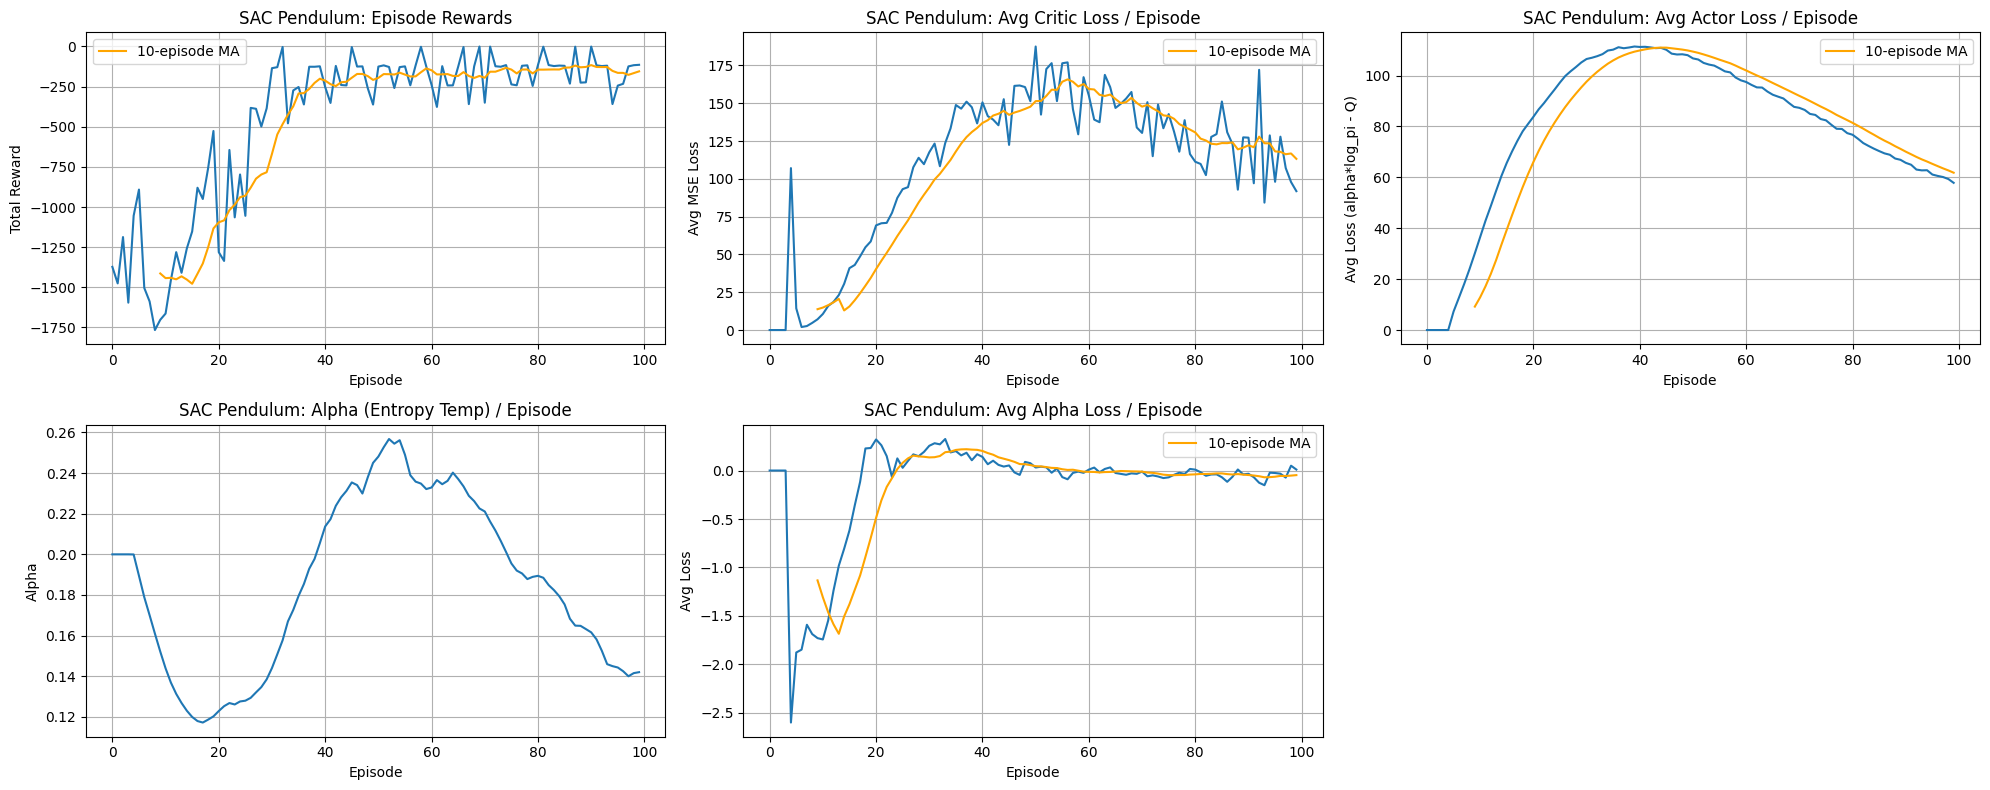

In [11]:
# Plotting results for SAC on Pendulum-v1
plt.figure(figsize=(20, 8))

# Episode Rewards
plt.subplot(2, 3, 1)
plt.plot(sac_episode_rewards)
plt.title('SAC Pendulum: Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
if len(sac_episode_rewards) >= 10:
    rewards_ma_sac = np.convolve(sac_episode_rewards, np.ones(10)/10, mode='valid')
    plt.plot(np.arange(len(rewards_ma_sac)) + 9, rewards_ma_sac, label='10-episode MA', color='orange')
    plt.legend()

# Critic Loss
plt.subplot(2, 3, 2)
plt.plot(sac_episode_critic_losses)
plt.title('SAC Pendulum: Avg Critic Loss / Episode')
plt.xlabel('Episode')
plt.ylabel('Avg MSE Loss')
plt.grid(True)
if len(sac_episode_critic_losses) >= 10:
    closs_ma_sac = np.convolve(sac_episode_critic_losses, np.ones(10)/10, mode='valid')
    plt.plot(np.arange(len(closs_ma_sac)) + 9, closs_ma_sac, label='10-episode MA', color='orange')
    plt.legend()

# Actor Loss
plt.subplot(2, 3, 3)
plt.plot(sac_episode_actor_losses)
plt.title('SAC Pendulum: Avg Actor Loss / Episode')
plt.xlabel('Episode')
plt.ylabel('Avg Loss (alpha*log_pi - Q)')
plt.grid(True)
if len(sac_episode_actor_losses) >= 10:
    aloss_ma_sac = np.convolve(sac_episode_actor_losses, np.ones(10)/10, mode='valid')
    plt.plot(np.arange(len(aloss_ma_sac)) + 9, aloss_ma_sac, label='10-episode MA', color='orange')
    plt.legend()

# Alpha Value
plt.subplot(2, 3, 4)
plt.plot(sac_episode_alphas)
plt.title('SAC Pendulum: Alpha (Entropy Temp) / Episode')
plt.xlabel('Episode')
plt.ylabel('Alpha')
plt.grid(True)

# Alpha Loss (if auto-tuning)
if AUTO_TUNE_ALPHA:
    plt.subplot(2, 3, 5)
    plt.plot(sac_episode_alpha_losses)
    plt.title('SAC Pendulum: Avg Alpha Loss / Episode')
    plt.xlabel('Episode')
    plt.ylabel('Avg Loss')
    plt.grid(True)
    if len(sac_episode_alpha_losses) >= 10:
        alphloss_ma_sac = np.convolve(sac_episode_alpha_losses, np.ones(10)/10, mode='valid')
        plt.plot(np.arange(len(alphloss_ma_sac)) + 9, alphloss_ma_sac, label='10-episode MA', color='orange')
        plt.legend()

plt.tight_layout()
plt.show()

**Analysis of SAC Learning Curves (Pendulum):**

1.  **Episode Rewards:**
    The agent shows clear and relatively stable learning, with the moving average reward increasing significantly from around -1500 to approximately -200 within the first 40-50 episodes. The rewards plateau at a high level, indicating successful policy optimization for the pendulum swing-up task. The variance appears somewhat lower than DDPG, likely due to SAC's entropy regularization promoting smoother policy changes.

2.  **Avg Critic Loss / Episode:**
    Similar to DDPG, the critic's MSE loss increases substantially during training. This reflects the critic adapting to the improving policy and higher target Q-values associated with better performance (less negative rewards). While rising loss can sometimes indicate instability, here it likely corresponds to the increasing scale of Q-values in this task, and the stable rewards suggest the critic learning is functional.

3.  **Avg Actor Loss / Episode:**
    The actor loss (representing `alpha*log_pi - Q`) increases initially and then gradually decreases after peaking around episode 40. This complex objective aims to maximize both expected return (high Q) and policy entropy (high log\_pi). The peak likely corresponds to the point where entropy regularization (`alpha*log_pi`) dominates, after which the focus shifts towards maximizing Q-values, causing the overall loss (which is minimized, so the objective is maximized) to decrease.

4.  **Alpha (Entropy Temp) / Episode:**
    The automatic entropy tuning parameter, alpha, exhibits interesting behavior. It decreases initially, suggesting the agent is quickly becoming more confident (reducing entropy), then increases significantly until episode ~55, indicating a need for more exploration perhaps to escape a local optimum or adapt to higher value states, before finally decreasing again as the policy converges and becomes more deterministic. This dynamic adjustment is key to SAC's exploration-exploitation balance.

5.  **Avg Alpha Loss / Episode:**
    The loss associated with tuning alpha shows an initial negative spike, then rises and stabilizes close to zero. This loss aims to drive alpha such that the policy entropy matches a target value. Its stabilization near zero indicates the automatic tuning mechanism has converged, successfully balancing the policy's entropy according to the target.

**Overall Conclusion:**
SAC demonstrates effective and relatively stable learning on the continuous Pendulum task, achieving high rewards comparable to DDPG but potentially with less reward variance. The automatic entropy tuning (alpha) actively adjusts the exploration level throughout training, contributing to robust learning. The critic and actor losses show trends consistent with SAC's maximum entropy objective and the dynamics of the Pendulum environment.

# Analyzing the Learned Policy (Testing)

Visualize the performance of the trained SAC agent by running it deterministically (using the mean action from the policy distribution) in the environment.

In [12]:
def test_sac_agent(actor_net: ActorNetworkSAC, 
                   env_instance: gym.Env, 
                   num_episodes: int = 5, 
                   render: bool = False, 
                   seed_offset: int = 2000) -> None:
    """
    Tests the trained SAC agent using the mean action (deterministically).
    """
    if env_instance is None:
        print("Environment not available for testing.")
        return
        
    actor_net.eval() # Set actor to evaluation mode
    
    print(f"\n--- Testing SAC Agent ({num_episodes} episodes, Deterministic) ---")
    all_rewards = []
    for i in range(num_episodes):
        state_np, info = env_instance.reset(seed=seed + seed_offset + i)
        state = torch.from_numpy(state_np).float().to(device)
        episode_reward = 0
        done = False
        t = 0
        while not done:
            if render:
                try:
                    env_instance.render()
                    time.sleep(0.01)
                except Exception as e:
                    print(f"Rendering failed: {e}. Disabling render.")
                    render = False
            
            with torch.no_grad():
                # --- Get Deterministic Action (Mean) --- 
                # Forward pass to get mean, ignore sampled action and log_prob
                x = F.relu(actor_net.layer1(state))
                x = F.relu(actor_net.layer2(x))
                mean = actor_net.mean_layer(x)
                action_deterministic = torch.tanh(mean) * actor_net.action_high_bound
                # -----------------------------------------
                action = action_deterministic.cpu().numpy()
            
            # Clipping just in case
            action_clipped = np.clip(action, env_instance.action_space.low, env_instance.action_space.high)
            
            next_state_np, reward, terminated, truncated, _ = env_instance.step(action_clipped)
            done = terminated or truncated
            state = torch.from_numpy(next_state_np).float().to(device)
            episode_reward += reward
            t += 1
        
        print(f"Test Episode {i+1}: Reward = {episode_reward:.2f}, Length = {t}")
        all_rewards.append(episode_reward)
        if render:
             env_instance.close()

    print(f"--- Testing Complete. Average Reward: {np.mean(all_rewards):.2f} ---")

# Run test episodes
test_sac_agent(actor_sac, env, num_episodes=3, render=False) # Set render=True if desired


--- Testing SAC Agent (3 episodes, Deterministic) ---
Test Episode 1: Reward = -0.47, Length = 200
Test Episode 2: Reward = -123.35, Length = 200
Test Episode 3: Reward = -0.76, Length = 200
--- Testing Complete. Average Reward: -41.53 ---


## Common Challenges and Solutions in SAC

**Challenge: Hyperparameter Sensitivity (especially $\alpha$)**
*   **Problem:** Performance is sensitive to learning rates, $\tau$, batch size, and particularly the entropy temperature $\alpha$. A fixed $\alpha$ might be too high (excessive exploration, slow convergence) or too low (insufficient exploration, suboptimal policy).
*   **Solutions**:
    *   **Automated Alpha Tuning:** Implementing the automatic tuning of $\alpha$ based on a target entropy (as done in this notebook) is highly recommended and generally improves stability and performance across different tasks.
    *   **Careful Manual Tuning:** If not using auto-tuning, $\alpha$ needs careful manual tuning, often requiring experimentation.
    * **Standard Defaults:** Start with common values (e.g., LR=3e-4, $\tau$=5e-3, batch=256).

**Challenge: Choice of Target Entropy $\bar{H}$**
*   **Problem:** When auto-tuning $\alpha$, the choice of target entropy $\bar{H}$ can influence the resulting policy's exploration level. The heuristic $\bar{H} = -\text{dim}(\mathcal{A})$ is common but not always optimal.
*   **Solutions**:
    *   **Use Heuristic:** Start with $\bar{H} = -\text{dim}(\mathcal{A})$.
    *   **Experiment:** Try slightly different values for $\bar{H}$ if performance is unsatisfactory.

**Challenge: Implementation Details (Squashing Correction)**
*   **Problem:** Forgetting to apply the correction term to the log-probability due to the `tanh` squashing function is a common implementation error that significantly impacts performance.
  **Solution:** Ensure the log-probability calculation correctly subtracts $\log(1 - \tanh(z)^2)$, summed over the action dimensions.

**Challenge: Sample Efficiency on Very Complex Tasks**
*   **Problem:** While highly sample efficient due to off-policy learning, extremely complex environments might still require vast amounts of data.
   **Solutions**:
    *   **Distributed Training:** Use multiple actors collecting data in parallel (e.g., frameworks like RLLib).
    *   **Model-Based RL:** Incorporate a learned model of the environment dynamics to generate additional simulated data.
    * **Offline RL:** If sufficient pre-collected data is available, offline RL variants can be used.

## Conclusion

Soft Actor-Critic (SAC) is a powerful off-policy actor-critic algorithm that excels in continuous control tasks by incorporating the maximum entropy framework. By optimizing for both reward and policy entropy, SAC encourages robust exploration and often achieves state-of-the-art performance with high sample efficiency and stability.

Key features like the stochastic policy with reparameterization, twin Q-critics with soft target updates, and often automated tuning of the entropy temperature ($\alpha$) contribute to its success. While still requiring careful hyperparameter tuning, SAC represents a significant advancement over DDPG and TD3, offering a compelling blend of performance, stability, and exploration capabilities, making it a popular choice for challenging continuous control problems in modern reinforcement learning.